In [195]:
from keras.layers import Lambda, Input, Dense
from keras.models import Model
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras.models import Sequential
from keras.layers import concatenate
from keras import backend as K
from keras.callbacks import Callback
from keras.layers import Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy import interpolate
import keras
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD
from keras.utils import to_categorical
from keras.models import load_model

In [184]:
filename = 'D:\\python\\cnn\\data.npz'

def Load_Data(filename):

  data = np.load(filename)
  Output = data['Output']
  Input_current = data['Input_current']
  Input_powergrid = data['Input_powergrid']
  data = {'Output':Output, 'Input_current':Input_current, 'Input_powergrid':Input_powergrid}
  return Output,Input_current,Input_powergrid

Output,Input_current,Input_powergrid = Load_Data(filename)
image_size = 32
original_dim = 1024

z_train = Input_powergrid.reshape(-1,Input_powergrid.shape[1])
iset=[]
jset=[]
kset=[]
for i in(range(Output.shape[0])):
    for j in(range(Output.shape[1])):
        for k in(range(Output.shape[2])):
            if Input_current[i][j][k] > 0:
                iset.append(i)
                jset.append(j)
                kset.append(k)
    #zz_train = 1 - zz_train          
    #t_train = np.concatenate((zz_train,z_train),axis=1)
#print(len(iset))
#print(len(jset))
#print(len(kset))
for i in(range(len(iset))):
    minc=max(0,kset[i]-2)
    maxc=min(31,kset[i]+2)
    minl=max(0,jset[i]-2)
    maxl=min(31,jset[i]+2)
    x=iset[i]
    y=jset[i]
    z=kset[i]
    value = Input_current[x][y][z]
    #print(value)
    for j in(range(minl,maxl)):
        for k in(range(minc,maxc)):
            Input_current[x][j][k]=value

zz_train = Input_current.reshape(-1,original_dim)
            
print(Input_current[1])
#t_train = zz_train
#x_test = Input_current.reshape(-1,original_dim)
#x_test = t_train[2000:]
#x_train = t_train
x_train = z_train[:2000]
x_test = z_train[2000:]
xx_train = zz_train[:2000]
xx_test = zz_train[2000:]
yy_train = Output.reshape(-1,original_dim)
y_test = yy_train[2000:]
y_train = yy_train[:2000]
#y_test = Output.reshape(-1,original_dim)
print(sum(zz_train[0]))
print(y_train[0])
print(y_test.shape)

[[0.       0.       0.654545 ... 0.       0.       0.      ]
 [0.       0.       0.654545 ... 0.       0.       0.      ]
 [0.       0.       0.654545 ... 0.       0.       0.      ]
 ...
 [0.       0.       0.       ... 0.       0.       0.      ]
 [0.       0.       0.       ... 0.       0.       0.      ]
 [0.       0.       0.       ... 0.       0.       0.      ]]
97.91999999999989
[0.79380939 0.79380869 0.79380619 ... 0.79569875 0.79571475 0.795718  ]
(761, 1024)


In [4]:
def root_mean_squared_error(y_true, y_pred): 
     return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1)) 
input_img = Input(shape=(32, 32, 1))    
#def training_model(x_train,y_train,batch_size,epochs):
model = Sequential()
  # input: 180x320 images with 3 channels -> (180, 320, 3) tensors.
  # this applies 32 convolution filters of size 3x3 each.
  #1024->128>8*8 +6 = 70->64-> 128->1024
model.add(Dense(256, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(1024, activation='softmax'))
  #sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
  #model.compile(loss='categorical_crossentropy', optimizer='rmsprop',metric
model.compile(optimizer = "rmsprop", loss = root_mean_squared_error,metrics =["accuracy"])
  #model.compile(loss='categorical_crossentropy', optimizer=sgd,metrics=['accuracy'])
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.3)
#  return model,history

input1 = keras.layers.Input(shape=(1024,))
x1 = keras.layers.Dense(8, activation='relu')(input1)
input2 = keras.layers.Input(shape=(6,))
x2 = keras.layers.Dense(8, activation='relu')(input2)
conatenated = keras.layers.conatenate([x1, x2],axis=1)
 
out = keras.layers.Dense(4)(conatenated)
model = keras.models.Model(inputs=[input1, input2], outputs=out)

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(inputs=input_img, outputs=decoded)
autoencoder.compile(optimizer='adagrad', loss='binary_crossentropy')

autoencoder.fit(x_train, x_train, epochs=50, batch_size=256,
                shuffle=True, validation_data=(x_test, x_test),
                callbacks=[TensorBoard(log_dir='autoencoder')])

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(100, 100, 3)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
 
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
 
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))


model.summary()

NameError: name 'batch_size' is not defined

In [115]:

# define two sets of inputs
def root_mean_squared_error(y_true, y_pred): 
     return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1)) 
#input_img = Input(shape=(32, 32, 1))    
#def training_model(x_train,y_train,batch_size,epochs):
model = Sequential()
inputA = Input(shape=(6,))
inputB = Input(shape=(1024,))
# the first branch operates on the first input
#x = Dense(6, activation="relu")(inputA)
#x = Dense(4, activation="relu")(x)
#x = Model(inputs=inputA, outputs=x)
# the second branch opreates on the second input
y = Dense(256, activation="relu")(inputB)
#y = Dense(64, activation="relu")(y)
#y = Dense(16, activation="relu")(y)
#y = Dense(4, activation="relu")(y)
#y = Model(inputs=inputB, outputs=y)
# combine the output of the two branches
#combined = concatenate([x.output, y.output])
# apply a FC layer and then a regression prediction on the
# combined outputs
z = Dense(256, activation="relu")(y)
#z = Dense(64, activation="relu")(z)
#z = Dense(256, activation="relu")(z)
z = Dense(1024, activation="relu",use_bias = True)(z)

#z = Dense(1, activation="linear")(z)
# our model will accept the inputs of the two branches and
# then output a single value
#model = Model(inputs=[x.input, y.input], outputs=z)
model = Model(inputs=inputB,outputs=z)
model.compile(optimizer = "rmsprop", loss = root_mean_squared_error,metrics =["accuracy"])
#history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.3)
#history = model.fit(x=[x_train, xx_train], y=y_train,validation_data=([x_test, xx_test], y_test),epochs=20, batch_size=8)
history = model.fit(xx_train, y_train,validation_data=(xx_test, y_test),epochs=20, batch_size=8)

Train on 2000 samples, validate on 761 samples
Epoch 1/20
2000/2000 [==============================] - 2s 1ms/step - loss: 0.4469 - accuracy: 5.0000e-04 - val_loss: 0.4089 - val_accuracy: 0.0013
Epoch 2/20
2000/2000 [==============================] - 2s 960us/step - loss: 0.3850 - accuracy: 0.0015 - val_loss: 0.3726 - val_accuracy: 0.0013
Epoch 3/20
2000/2000 [==============================] - 2s 944us/step - loss: 0.3610 - accuracy: 0.0010 - val_loss: 0.3532 - val_accuracy: 0.0000e+00
Epoch 4/20
2000/2000 [==============================] - 2s 987us/step - loss: 0.3490 - accuracy: 0.0015 - val_loss: 0.3456 - val_accuracy: 0.0000e+00
Epoch 5/20
2000/2000 [==============================] - 2s 987us/step - loss: 0.3425 - accuracy: 0.0025 - val_loss: 0.3396 - val_accuracy: 0.0000e+00
Epoch 6/20
2000/2000 [==============================] - 2s 984us/step - loss: 0.3356 - accuracy: 0.0000e+00 - val_loss: 0.3339 - val_accuracy: 0.0000e+00
Epoch 7/20
2000/2000 [==============================] -

In [15]:
# define two sets of inputs
inputA = Input(shape=(32,))
inputB = Input(shape=(128,))
# the first branch operates on the first input
x = Dense(8, activation="relu")(inputA)
x = Dense(4, activation="relu")(x)
x = Model(inputs=inputA, outputs=x)
# the second branch opreates on the second input
y = Dense(64, activation="relu")(inputB)
y = Dense(32, activation="relu")(y)
y = Dense(4, activation="relu")(y)
y = Model(inputs=inputB, outputs=y)
# combine the output of the two branches
combined = concatenate([x.output, y.output])
# apply a FC layer and then a regression prediction on the
# combined outputs
z = Dense(2, activation="relu")(combined)
z = Dense(1, activation="linear")(z)
# our model will accept the inputs of the two branches and
# then output a single value

[0.7697148  0.7649214  0.76045084 ... 0.77220476 0.7677882  0.76939183]
[0.79000025 0.79000611 0.79002775 ... 0.79804825 0.79804275 0.798041  ]


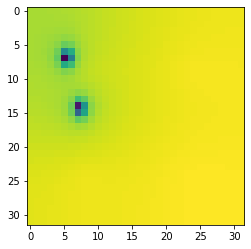

In [116]:
#y_prediction = model.predict([x_train,xx_train])
y_prediction = model.predict(xx_train)
print(y_prediction[7])
print(y_train[7])
plt.imshow(y_train[7].reshape(32, 32))
plt.show()

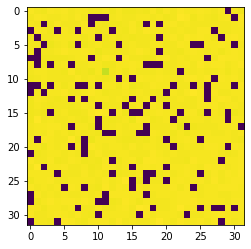

0.0
[0.77187216 0.76742965 0.76578677 ... 0.77361715 0.77050185 0.7717877 ]
[0.7726419  0.7673607  0.7645923  ... 0.77393293 0.7702391  0.7718134 ]


In [118]:
plt.imshow(y_prediction[78,:].reshape(32, 32))
plt.show()
#print(np.nonzero(y_prediction[7]))
print(min(y_prediction[7]))
print(y_prediction[2])
print(y_prediction[3])

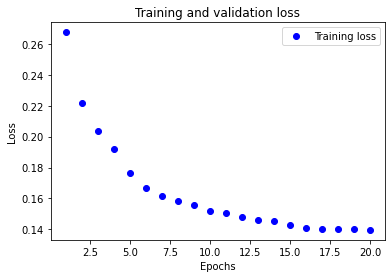

In [49]:

history_dict = history.history
loss_values = history_dict['loss']
#val_loss_values = history_dict['val_loss']

epochs = range(1, len(loss_values) + 1)

plt.plot(epochs, loss_values, 'bo', label='Training loss')
#plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


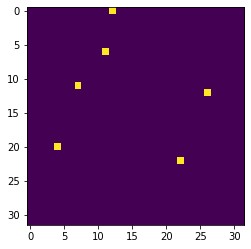

In [100]:
plt.imshow(xx_train[200].reshape(32, 32))
plt.show()

In [76]:

function min(arr){
  arr = arr.filter(item => !_isNaN(item))
  return arr.length ? Math.min.apply(null, arr) : undefined
}

result = min(y_predition[2])

SyntaxError: invalid syntax (<ipython-input-76-22afa8bd9eca>, line 1)

In [85]:
print(max(xx_train[7]))

3.5999999999999996


In [113]:
for i in(range(y_prediction[7].shape[0])):
  if y_prediction[7][i] == 0 :
    y_prediction[7][i] = 

NameError: name 'nah' is not defined

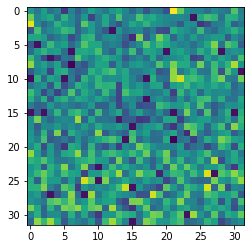

In [102]:
plt.imshow(y_prediction[7].reshape(32, 32))
plt.show()

In [112]:
y_train[7].interpolate()

AttributeError: 'numpy.ndarray' object has no attribute 'interpolate'

In [205]:
def root_mean_squared_error(y_true, y_pred): 
     return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1))

Input_current1=np.expand_dims(Input_current,axis=2)
print(Input_current1.shape)
Input_current1=np.transpose(Input_current1,(0,1,3,2))

Output1=np.expand_dims(Output,axis=2)
#print(y_train1.shape)
Output1=np.transpose(Output1,(0,1,3,2))
#y_test1=np.expand_dims(y_test,axis=2)
#y_test1=np.transpose(y_test1,(0,1,3,2))

#Input_current= np.squeeze(Input_current)
print(Input_current1.shape)
Input_train = Input_current1[:2000]
Input_test = Input_current1[2000:]
Output_train = Output1[:2000]
Output_test = Output1[2000:]
input_img = Input(shape=(32, 32, 1))
x = Conv2D(128, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
#x = MaxPooling2D((2, 2), padding='same')(x)
#x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

#x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
#x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu',padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='softmax', padding='same')(x)
autoencoder.summary()
autoencoder = Model(inputs=input_img, outputs=decoded)
#autoencoder.compile(optimizer='adagrad', loss='binary_crossentropy')
#from keras.callbacks import TensorBoard, CSVLogger, EarlyStopping
#callbacks=[TensorBoard(log_dir='autoencoder')] rmsprop
sgd = SGD(lr=0.0001, decay=1e-6, momentum=0.9, nesterov=True)
autoencoder.compile(optimizer = "sgd", loss = root_mean_squared_error,metrics =["accuracy"])
learning_rate = 0.001
#autoencoder.compile(tf.compat.v1.train.GradientDescentOptimizer(learning_rate),loss=tf.keras.metrics.mean_squared_error,metrics=[tf.keras.metrics.RootMeanSquaredError()])
autoencoder.fit(Input_train, Output_train, epochs=10, batch_size=16,validation_data=(Input_test, Output_test))


(2761, 32, 1, 32)
(2761, 32, 32, 1)
Model: "model_76"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_81 (InputLayer)        (None, 32, 32, 1)         0         
_________________________________________________________________
conv2d_230 (Conv2D)          (None, 32, 32, 128)       1280      
_________________________________________________________________
max_pooling2d_98 (MaxPooling (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_231 (Conv2D)          (None, 16, 16, 16)        18448     
_________________________________________________________________
max_pooling2d_99 (MaxPooling (None, 8, 8, 16)          0         
_________________________________________________________________
conv2d_232 (Conv2D)          (None, 8, 8, 16)          2320      
_________________________________________________________________
up_sampling2d_95 (UpSa

[[[1.]
  [1.]
  [1.]
  ...
  [1.]
  [1.]
  [1.]]

 [[1.]
  [1.]
  [1.]
  ...
  [1.]
  [1.]
  [1.]]

 [[1.]
  [1.]
  [1.]
  ...
  [1.]
  [1.]
  [1.]]

 ...

 [[1.]
  [1.]
  [1.]
  ...
  [1.]
  [1.]
  [1.]]

 [[1.]
  [1.]
  [1.]
  ...
  [1.]
  [1.]
  [1.]]

 [[1.]
  [1.]
  [1.]
  ...
  [1.]
  [1.]
  [1.]]]


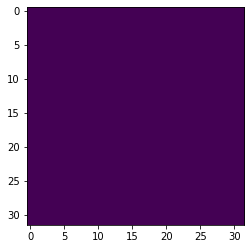

In [206]:
Output_prediction = autoencoder.predict(Input_train)
#print(y_prediction[7])
print(Output_prediction[82])
plt.imshow(Output_prediction[82].reshape(32, 32))
plt.show()

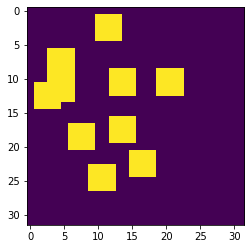

In [201]:
plt.imshow(Input_train[82].reshape(32, 32))
plt.show()